In [1]:
import scanpy as sc
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import json
from matplotlib import rcParams

In [2]:
# File path
file_path = "../../Database/Ravi_Cancer_Cell_2022/10XVisium_2/#"
folders = ['UKF260_T_ST']

In [3]:
# Load the json file for spatial scale factors


# JSON 파일 읽기
with open(file_path + folders[0] + '/outs/spatial/scalefactors_json.json', 'r') as file:
    scale_factors = json.load(file)

scale_factors


{'spot_diameter_fullres': 40.38790523664806,
 'tissue_hires_scalef': 0.4,
 'fiducial_diameter_fullres': 65.24200076689301,
 'tissue_lowres_scalef': 0.12}

In [4]:
# Load the spot data
spot_data = pd.read_csv(file_path + folders[0] +'/outs/spatial/tissue_positions_list.csv', header = None)
spot_data.columns = ['barcode', 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres']

In [5]:
# Load stRNA-seq data
adata = sc.read_10x_h5(file_path + folders[0] + "/outs/filtered_feature_bc_matrix.h5")
adata.var_names_make_unique()

adata.uns['spatial'] = {
    folders[0]: {
        'scalefactors': scale_factors,
        'images': {
            'hires': Image.open(file_path + folders[0] + '/outs/spatial/tissue_hires_image.png'),
            'lowres': Image.open(file_path + folders[0] + '/outs/spatial/tissue_lowres_image.png')
        },
        'type': 'visium'
    }
}

/home/jsw/jswenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jsw/jswenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [6]:
# 기존 anndata의 obs에서 spot_id를 가져와 위치 정보 추가
spot_ids = spot_data.set_index('barcode')
adata.obs = adata.obs.join(spot_ids[['pxl_col_in_fullres', 'pxl_row_in_fullres']], how='left')
adata.obsm['spatial'] = adata.obs[['pxl_col_in_fullres', 'pxl_row_in_fullres']].values

In [7]:
# normalize anndata
# sc.pp.log1p(adata)

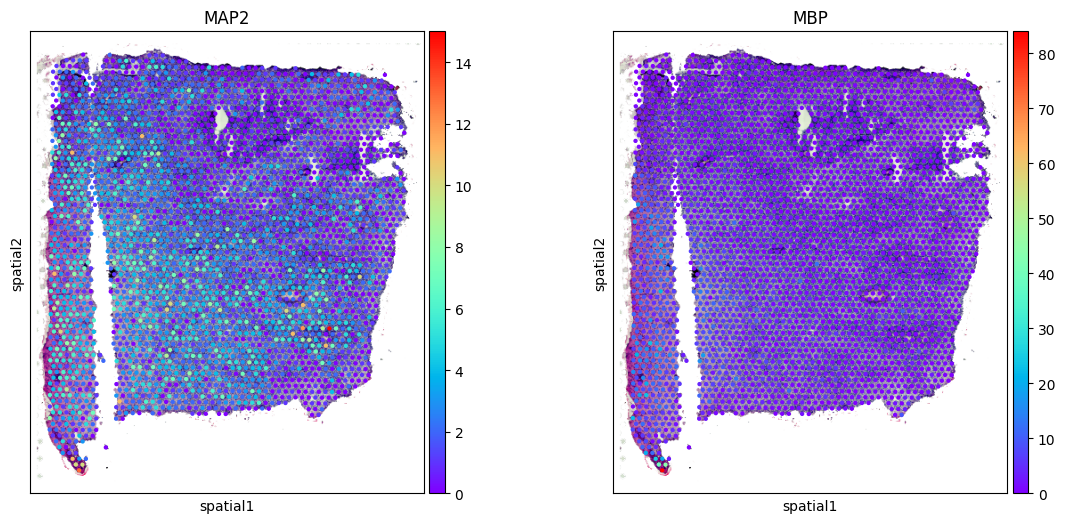

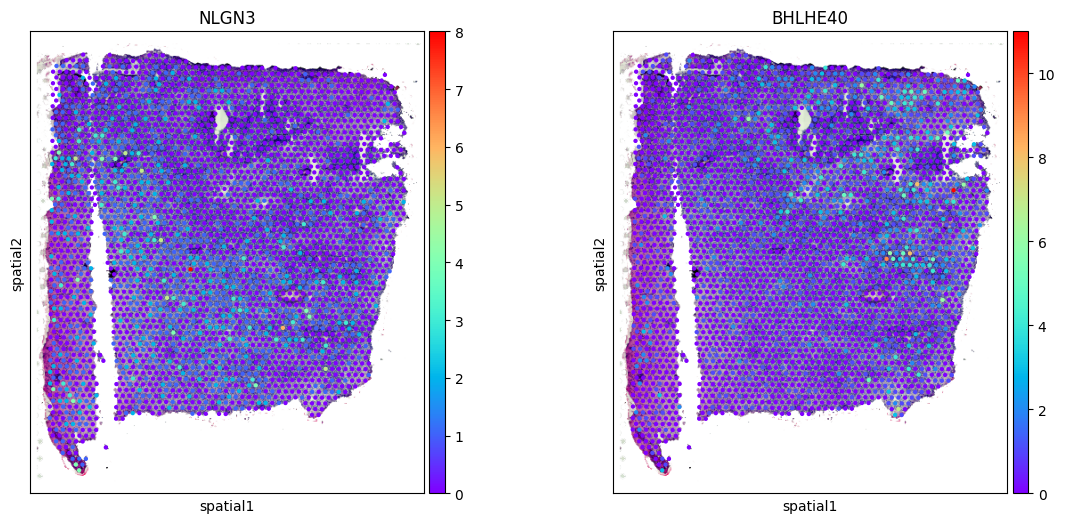

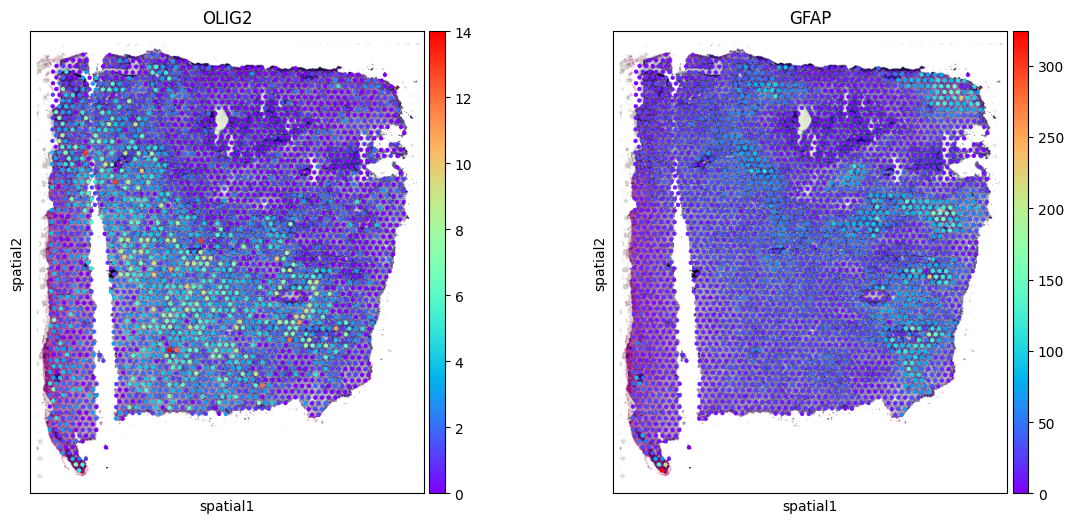

In [7]:
# Plot images
rcParams['figure.figsize'] = 6, 6

# 특정 유전자의 공간 발현 시각화
sc.pl.spatial(adata, color=['MAP2', 'MBP'], img_key = 'lowres', alpha_img = 1, alpha = 1, cmap = 'rainbow')
sc.pl.spatial(adata, color=['NLGN3', 'BHLHE40'], img_key = 'lowres', alpha_img = 1, alpha = 1, cmap = 'rainbow')
sc.pl.spatial(adata, color=['OLIG2', 'GFAP'], img_key = 'lowres', alpha_img = 1, alpha = 1, cmap = 'rainbow')


# cell2location

---

In [8]:

adata.var['SYMBOL'] = adata.var_names   # save var_names to 'SYMBOL'

In [9]:
adata.var.set_index('gene_ids', drop = True, inplace = True)    # set ENSEMBL ID as index

In [11]:
adata.var

feature_types  genome       SYMBOL
gene_ids                                             
ENSG00000243485  Gene Expression  GRCh38  MIR1302-2HG
ENSG00000237613  Gene Expression  GRCh38      FAM138A
ENSG00000186092  Gene Expression  GRCh38        OR4F5
ENSG00000238009  Gene Expression  GRCh38   AL627309.1
ENSG00000239945  Gene Expression  GRCh38   AL627309.3
...                          ...     ...          ...
ENSG00000277856  Gene Expression  GRCh38   AC233755.2
ENSG00000275063  Gene Expression  GRCh38   AC233755.1
ENSG00000271254  Gene Expression  GRCh38   AC240274.1
ENSG00000277475  Gene Expression  GRCh38   AC213203.1
ENSG00000268674  Gene Expression  GRCh38      FAM231C

[33538 rows x 3 columns]

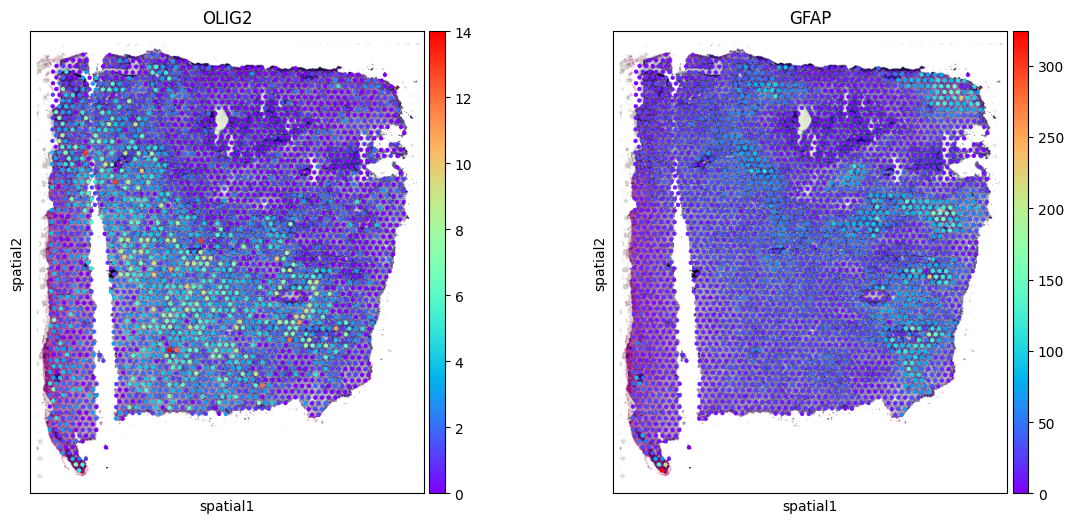

In [12]:
sc.pl.spatial(adata, color=['OLIG2', 'GFAP'], img_key = 'lowres', alpha_img = 1, alpha = 1, cmap = 'rainbow', gene_symbols='SYMBOL')

In [13]:
# remove mitochondrial genes
adata.var['MT_gene'] = [gene.startswith('MT-') for gene in adata.var['SYMBOL']]

adata.obsm['MT'] = adata[:, adata.var['MT_gene'].values].X.toarray()
adata = adata[:, ~adata.var['MT_gene'].values]

In [14]:
adata

View of AnnData object with n_obs × n_vars = 2997 × 33525
    obs: 'pxl_col_in_fullres', 'pxl_row_in_fullres'
    var: 'feature_types', 'genome', 'SYMBOL', 'MT_gene'
    uns: 'spatial'
    obsm: 'spatial', 'MT'

---

In [15]:
import numpy as np

In [16]:
inf_aver = pd.read_csv('../data/inf_aver.csv', index_col = 0)

intersect = np.intersect1d(adata.var_names, inf_aver.index)
# intersect.shape

adata = adata[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

In [17]:
adata.obs['sample'] = 'UKF260_T_ST'

In [18]:
adata.obs

pxl_col_in_fullres  pxl_row_in_fullres       sample
AAACAATCTACTAGCA-1                1923                 566  UKF260_T_ST
AAACAGAGCGACTCCT-1                3501                1176  UKF260_T_ST
AAACAGCTTTCAGAAG-1                 845                2718  UKF260_T_ST
AAACAGGGTCTATATT-1                 968                2935  UKF260_T_ST
AAACATGGTGAGAGGA-1                 556                3742  UKF260_T_ST
...                                ...                 ...          ...
TTGTTGTGTGTCAAGA-1                2964                2090  UKF260_T_ST
TTGTTTCACATCCAGG-1                1863                3538  UKF260_T_ST
TTGTTTCATTAGTCTA-1                1489                3643  UKF260_T_ST
TTGTTTCCATACAACT-1                1404                2831  UKF260_T_ST
TTGTTTGTGTAAATTC-1                2169                 784  UKF260_T_ST

[2997 rows x 3 columns]

In [19]:
import cell2location
# Prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(
    adata = adata,
    batch_key = 'sample'
)

/home/jsw/jswenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-31 14:15:58.282963: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-31 14:15:58.291431: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-31 14:15:58.293965: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-31 14:15:58.731381: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find

In [20]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata,
    cell_state_df = inf_aver,
    N_cells_per_location = 20,
    detection_alpha = 200
)

In [21]:
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.2.0.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 2997  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 11230 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories  ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ UKF260_T_ST │          0          │
└─────────────────────┴─────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [24]:
mod.train(max_epochs=3000, batch_size = None, train_size = 1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/jsw/jswenv/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/jsw/jswenv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/jsw/jswenv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 3000/3000: 100%|██████████| 3000/3000 [03:37<00:00, 13.87it/s, v_num=1, elbo_train=1.65e+7]

`Trainer.fit` stopped: `max_epochs=3000` reached.


Epoch 3000/3000: 100%|██████████| 3000/3000 [03:37<00:00, 13.82it/s, v_num=1, elbo_train=1.65e+7]


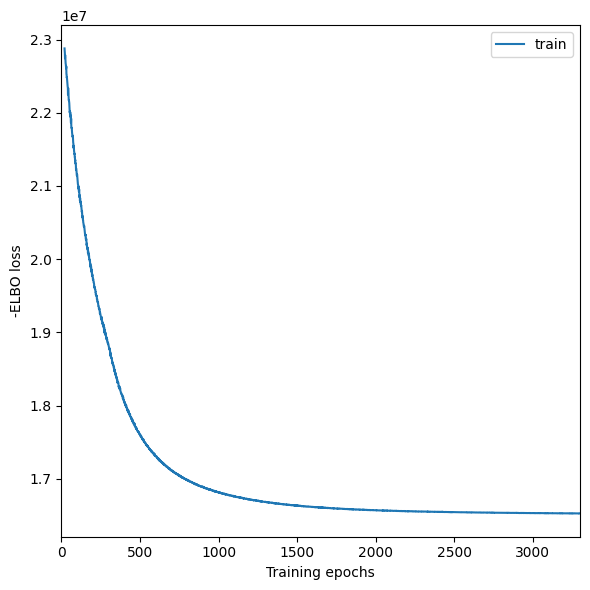

In [25]:
mod.plot_history(20)

In [27]:
adata = mod.export_posterior(
    adata, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs}
)

Sampling global variables, sample: 100%|██████████| 999/999 [00:11<00:00, 86.76it/s]


In [29]:
mod.save('model2', overwrite = True)

In [30]:
mod = cell2location.models.Cell2location.load('model2', adata)

INFO     File model2/model.pt already downloaded                                                                   


/home/jsw/jswenv/lib/python3.10/site-packages/scvi/model/base/_save_load.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=map

Epoch 1/30000:   0%|          | 1/30000 [00:00<33:02, 15.13it/s, v_num=1]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/30000:   0%|          | 1/30000 [00:00<34:03, 14.68it/s, v_num=1]


In [31]:
adata

AnnData object with n_obs × n_vars = 2997 × 11230
    obs: 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'sample', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'genome', 'SYMBOL', 'MT_gene'
    uns: 'spatial', '_scvi_uuid', '_scvi_manager_uuid', 'mod'
    obsm: 'spatial', 'MT', 'means_cell_abundance_w_sf', 'stds_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf'

In [32]:
mod.plot_QC()

RuntimeError: self.samples is missing, please run self.export_posterior() first

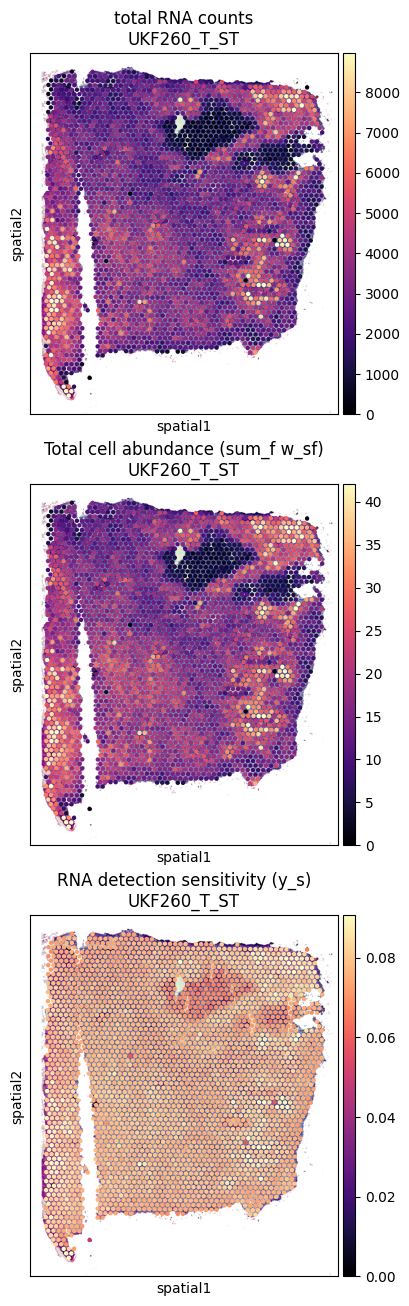

In [33]:
fig = mod.plot_spatial_QC_across_batches()

In [ ]:
adata_